In [175]:
import sympy as sp
sp.init_printing()

import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os

import yaml
import hashlib

### TODO

- Integrate assumptions

In [350]:
N = sp.symbols("N", integer=True)
t = sp.symbols('t')
_N = 2

γ = sp.symbols('γ')
E0, L, w1, σc = sp.symbols('E0 L w1 σc', positive = True)

u = sp.symbols([f"u{i}" for i in range(0, _N)])
e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
α = sp.symbols([f"α{i}" for i in range(1, _N+1)])
_α = sp.symbols("α")



β = sp.symbols('β')



In [3]:
state = {"u": u, "α": α, "e": e}
_matpar = {N: _N, γ: 2, E0: 1, w1: 1, L: 1}
matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}



In [4]:
_a = sp.Function('a')
_w = sp.Function('w')
_s = sp.Function('s')


In [5]:
_s = 1/_a(_α)

In [6]:
_s

1/a(α)

In [7]:
_ap = sp.diff(_a(_α), _α)

In [8]:
class SymbolicDiscreteDamage:
    def __init__(self, state, matpar, 
                 name="discrete generalised damage",
                 slug="general damage"):
        """
        Initialize a SymbolicDiscreteDamage object.

        Args:
            state (dict): The state containing alpha and epsilon values.
            matpar (dict): A dictionary of material parameters.
            name (str): The name of the damage model (optional).
            slug (str): The slug for the damage model (optional).
        """


        self.state = state
        self.matpar = matpar
        self.str = name
        self.slug = slug

    def _s(self, αi):
        """
        Placeholder for a function related to 's'.

        Args:
            αi: A parameter.

        Returns:
            sympy.Function: A function related to 's'.
        """
        s = sp.Function('s')
        # s = 1/self._a(αi)
        return s(αi)

    def _a(self, αi):
        """
        Placeholder for a function related to 'a'.

        Args:
            αi: A parameter.

        Returns:
            sympy.Function: A function related to 'a'.
        """

        γ = self.matpar["γ"]
        a = sp.Function('a')
        return a(αi)
    
    def energy(self, state):
        """
        Calculate the total energy.

        Args:
            state (dict): The state containing alpha and epsilon values.

        Returns:
            sympy.Expr: The expression representing the total energy.
        """
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        """
        Calculate the work done.

        Args:
            state (dict): The state containing alpha and epsilon values.

        Returns:
            int: The work done.
        """
        return 0

    def _elastic(self, state):
        """
        Calculate the elastic energy.

        Args:
            state (dict): The state containing alpha and epsilon values.

        Returns:
            sympy.Expr: The expression representing elastic energy.
        """
        _e = state["e"]
        _α = state["α"]
        # _w1 = matpar["w1"]
        _E0 = self.matpar["E0"]
        _N = self.matpar["N"]
    
        return sum([1./2. * _E0 * self._a(_α[i]) * _e[i]**2 for i in range(len(α))])

    def _w(self, αi):
        """
        Placeholder for a function related to 'w'.

        Args:
            αi: A parameter.

        Returns:
            sympy.Function: A function related to 'w'.
        """
        w = sp.Function('w')

        return w(αi)

    def _damage(self, state):
        """
        Calculate the damage energy.

        Args:
            state (dict): The state containing alpha and epsilon values.

        Returns:
            sympy.Expr: The expression representing damage energy.
        """
        _α = state["α"]
        _w1 = self.matpar["w1"]

        _N = self.matpar["N"]

        return sum([_w1 / _N * self._w(_α[i]) for i in range(len(_α))]) 
        # return _w1 * self._w(_α)


    # Explicit expressions
    def w(self, αi):
        """
        Calculate 'w' explicitly.

        Args:
            αi: A parameter.

        Returns:
            float: The value of 'w'.
        """
        return αi

    def a(self, αi):
        """
        Calculate 'a' explicitly.

        Args:
            αi: A parameter.

        Returns:
            float: The value of 'a'.
        """
        γ = self.matpar["γ"]

        return (1 - self._w(αi)) / ((γ-1) * self._w(αi) + 1)

    def s(self, αi):
        """
        Calculate 's' explicitly.

        Args:
            αi: A parameter.

        Returns:
            float: The value of 's'.
        """

        return 1. / self.a(αi)


    def __str__(self):
        """
        Return the string representation of the damage model.

        Returns:
            str: The string representation of the damage model.
        """
        return self.str


In [318]:
class ModelAnalysis:
    """Helper class to analyse stability properties of a model"""

    def __init__(self, model):
        """
        Initialize a ModelAnalysis object.

        Args:
            model (ModelType): The model to be analyzed.
        """

        self.model = model
        self.state = model.state
        _state = self.state
        self.matpar = model.matpar

        _β = sp.symbols('β')
        _e = sp.symbols('e')
        self._β = _β
        self._e = _e
        
        self._s = model._s(_β)
        self._sp = sp.diff(self._s, _β, 1)
        self._spp = sp.diff(self._s, _β, 2)

        self._a = model._a(_β)
        self._ap = sp.diff(self._a, _β, 1)
        self._app = sp.diff(self._a, _β, 2)

        self._w = model._w(_β)
        self._wp = sp.diff(self._w, _β)
        self._wpp = sp.diff(self._w, _β, 2)

        # self.criterion()


    def criterion(self):
        """
        Calculate the damage onset criterion.

        Returns:
            sympy.Expr: The expression representing the damage onset criterion.
        """

        model, state = self.model, self.state
        x = sp.symbols('x')
        t = sp.symbols('t')
        L = sp.symbols('L')
        N = sp.symbols('N')

        β = self._β
        e = self._e

        # _u0 = t*x/L
        _e0 = t/L
        _alpha0 = 0

        _homogeneous_damage = {a: β for a in state["α"]}
        _homogeneous_strain = {a: e for a in state["e"]}
        _sound = {a: 0 for a in state["α"]}

        _crit = sp.diff(
            model.energy(state)                 \
                .subs(_homogeneous_damage)      \
                .subs(_homogeneous_strain), β)  \
                .subs({e: _e0, β: _alpha0})    

        self.crit = _crit

        return _crit

    def explicit_criterion(self):
        """
        Calculate the explicit form of the damage onset criterion.

        Returns:
            sympy.Expr: The explicit form of the damage onset criterion.
        """
        _model = self.model
        return self.crit.replace(sp.Function('a'), _model.a) \
                    .replace(sp.Function('w'), _model.w).doit()

    def bc_u(self):
        """
        Placeholder for a function related to boundary conditions.

        Note:
            This function does not have a specific implementation in the provided code.
        """
        pass

    def critical_load(self, matpar={}):
        """
        Calculate the critical load and associated criterion.

        Args:
            matpar (dict): A dictionary of material parameters.

        Returns:
            tuple: A tuple containing critical load values and the associated criterion.
        """

        criterion = self.crit           \
            .replace(_a, self.model.a)  \
            .replace(_w, self.model.w)
        t = sp.symbols('t')

        tc = sp.solve(criterion, t)
        
        if matpar:
            tc = [_tc.subs(matpar) for _tc in tc if _tc.subs(matpar).is_positive]
        
        return tc, criterion


    def _equilirbrium_e(self):
        """
        Calculate equilibrium strain values.

        Returns:
            list: List of equilibrium strain values for each alpha.
        """

        state = self.state
        t, L = sp.symbols('t L')
        N = sp.symbols('N')
        
        _S = sum([self.model._s(αi) for αi in state["α"]])

        _e = [(N * t/L * self.model._s(αi) / _S).simplify() \
                    for αi in state["α"]]

        return _e
    
    def equilibrium_subs(self):
        """
        Generate substitutions for equilibrium state.


        Returns:
            dict: A dictionary of substitutions for equilibrium state.
        """
        _ei = self._equilirbrium_e()
        state = self.state
        return {v[0]: v[1] for v in zip(state["e"], _ei)}
        

    def energy_fc_alpha(self):
        """
        Calculate energy as a function of alpha.


        Returns:
            sympy.Expr: The expression representing energy as a function of alpha.
        """
        state = self.state
        equilibrium_subs = self.equilibrium_subs()
        
        return self.model.energy(state).subs(equilibrium_subs)

    def _state_split(self, m, state, matpar):
        """
        Split the state into homogeneous and bifurcated parts.

        Args:
            m (int): A parameter for splitting.
            state (dict): The state containing alpha and epsilon values.
            matpar (dict): A dictionary of material parameters.

        Returns:
            tuple: A tuple containing lists of bifurcated and homogeneous alpha and epsilon values.
        """

        assert m < matpar[N]

        _bif_α = [state["α"][k+1] for k in range(m)]
        _bif_e = [state["e"][k+1] for k in range(m)]

        _homo_α = set(state["α"]) - set(_bif_α)
        _homo_e = set(state["e"]) - set(_bif_e)

        return _bif_α, _homo_α, _bif_e, _homo_e

    def _state_homog_substitutions(self, state, matpar):
        """
        Generate substitutions for the homogeneous state.

        Args:
            state (dict): The state containing alpha and epsilon values.
            matpar (dict): A dictionary of material parameters.

        Returns:
            tuple: A tuple containing dictionaries of substitutions for alpha and epsilon.
        """
        αt = sp.symbols('α_t')
        et = sp.symbols('e_t')

        _subs_αh = {a: αt for a in state["α"]}
        _subs_eh = {e: et for e in state["e"]}

        return _subs_αh, _subs_eh


    def _state_bifurcation_substitutions(self, m, state, matpar):
        """
            Compute substitutions for bifurcated states.
            
            Args:
            m (int): A parameter for splitting.
            state (dict): The state containing alpha and epsilon values.
            matpar (dict): A dictionary of material parameters.
            
            Returns:
            tuple: A tuple containing dictionaries of substitutions for alpha and epsilon.
            """
        
        assert m < matpar[N]
        _bif, _homo, _bif_e, _homo_e = self._state_split(m, state, matpar)
        _αb = sp.symbols("a^*")
        _eb = sp.symbols("e^*")
        αt = sp.symbols('α_t')
        et = sp.symbols('e_t')

        _subs_αb = {a: _αb for a in _bif}
        _subs_eb = {e: _eb for e in _bif_e}

        _subs_αt = {a: αt for a in _homo}
        _subs_et = {e: et for e in _homo_e}

        return {**_subs_αb, **_subs_αt}, {**_subs_eb, **_subs_et}


    def homogeneous_α(self, matpar = {}):
        """
            Solve the homogeneous evolution law for damage.
            
            Args:
            matpar (dict): A dictionary of material parameters.
            
            Returns:
            list: List of solutions for homogeneous evolution of alpha.
            """
        αt = sp.symbols('α_t')
        
        if matpar:
            return [sol.subs(matpar) for sol in \
                    list(map(sp.simplify, sp.solve(self.evo_α(matpar), αt)))]
        else:
            return list(map(sp.simplify, sp.solve(self.evo_α(), αt)))

    def set_homog_solution_idx(self, idx):
        """
            Set the index of the homogeneous solution.
            
            Args:
            idx (int): The index of the homogeneous solution.
            """
        self._homog_solution_idx = idx 

    def homogeneous_α_wrt_t(self, matpar = {}):
        t = sp.symbols('t')
        _tc, _ = self.critical_load()
        _tc = _tc[self._homog_solution_idx].subs(matpar)
        _ah = self.homogeneous_α(matpar)[self._homog_solution_idx]

        return sp.Piecewise((_ah, t >= _tc), (0, t < _tc))

    def homogeneous_α_wrt_t(self, matpar = {}):
        """
            Calculate homogeneous alpha as a function of time.
            
            Args:
            matpar (dict): A dictionary of material parameters.
            
            Returns:
            sympy.Piecewise: A piecewise function representing homogeneous alpha with respect to time.
            """
        t = sp.symbols('t')
        _tc, _ = self.critical_load()
        _tc = _tc[self._homog_solution_idx].subs(matpar)
        _ah = self.homogeneous_α(matpar)[self._homog_solution_idx]

        return sp.Piecewise((_ah, t >= _tc), (0, t < _tc))

    def evo_α(self, matpar = {}):
        """
            Calculate the evolution law for damage.
            
            Args:
            matpar (dict): A dictionary of material parameters.
            
            Returns:
            sympy.Expr: The expression representing the evolution law for damage.
            """
        αt = sp.symbols('α_t')
        state = self.state
        subs_homog_α, _ =  self._state_homog_substitutions(state, matpar)

        # return sp.diff(self.energy_fc_alpha().subs(subs_homog_α), αt)                   \
        #     .replace(_a, self.model.a)                  \
        #     .replace(_w, self.model.w)                  \
        #     .doit().simplify()
        

        return sp.diff(self.energy_fc_alpha().subs(subs_homog_α), αt)                   \
            .replace(sp.Function('a'), self.model.a)                  \
            .replace(sp.Function('w'), self.model.w)                  \
            .doit().simplify().subs(matpar)

    def plot_material(self, matpar):
        """
        Plot material behavior.

        Args:
            matpar (dict): A dictionary of material parameters.

        Returns:
            tuple: A tuple containing a figure and axis for the material behavior plot.
        """
        _model = self.model
        _α = sp.symbols('α')
        _damage = np.linspace(0., 1.)

        _ap = sp.diff(_model.a(_α).replace(sp.Function('w'), _model.w), _α)
        _app = sp.diff(_model.a(_α).replace(sp.Function('w'), _model.w), _α, 2)
        _wp = sp.diff(_model.w(_α), _α)

        _wf = sp.lambdify(_α, _model.w(_α).subs(matpar), "numpy")
        _af = sp.lambdify(_α, _model.a(_α).subs(matpar).replace(sp.Function('w'), _model.w), "numpy")
        _apf = sp.lambdify(_α, _ap.subs(matpar).simplify().subs(matpar), "numpy")
        _appf = sp.lambdify(_α, _app.subs(matpar).simplify().subs(matpar), "numpy")
        _wpf = sp.lambdify(_α, _wp.subs(matpar).simplify().subs(matpar), "numpy")


        _w, _a

        figure, axis = plt.subplots(1, 2, figsize=(8, 6))
        _ax = axis[0]
        _ax.axhline(0, c='k')
        _ax.plot(_damage, [_af(α) for α in _damage], label="a")
        _ax.plot(_damage, [_apf(α) for α in _damage], label="a'", c='r')
        _ax.plot(_damage, [_appf(α) for α in _damage], label="a''")
        _ax.legend(loc=2)

        _ax2 = _ax.twiny()
        left, bottom, width, height = [0.27, 0.6, 0.2, 0.2]
        _ax2 = figure.add_axes([left, bottom, width, height])

        _ax2.plot(_damage, [_wf(α) for α in _damage], label="w", c='k', ls='dashed')
        _ax2.set_ylabel('w')
        _ax.set_ylabel('a, a\', a\'\'')
        
        figure.suptitle(f"Behaviour of {self.model.__str__()} is Material \n {matpar}")

        return figure, axis

In [351]:
N = sp.symbols("N")
t = sp.symbols('t')
_N = 3

γ = sp.symbols('γ')
E0, L, w1, σc = sp.symbols('E0 L w1 σc')

u = sp.symbols([f"u{i}" for i in range(0, _N)])
e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
α = sp.symbols([f"α{i}" for i in range(1, _N+1)])
_α = sp.symbols("α")

β = sp.symbols('β')

state = {"u": u, "α": α, "e": e}
_matpar = {N: _N, γ: 2, E0: 1, w1: 1, L: 1}
matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}



In [352]:
_a = sp.Function('a')
_w = sp.Function('w')
_s = sp.Function('s')


In [353]:
_s = 1/_a(_α)

In [354]:
_matpar[sp.Symbol('L')]

In [355]:
_s

## The energy model
Discrete $N$-bar with imposed displacement $u_{N} = \bar u = N\frac{t}{L}$, the scaling of the load so that for each $N$ and $t$ springs of a homogeneous state are subject to the same strain. 

$$
\begin{aligned}
\mathcal E_N (e, \alpha) &=  E_0\sum_{i=0}^N \frac{1}{2}    a(\alpha_i)  e_i^2  + \sum_{i=0}^N {w_1}w(\alpha_i) \\
\tilde {\mathcal E}_N (u, \alpha) &=  E_0 N\sum_{i=0}^N \frac{1}{2}  a(\alpha_i)  (u_i-u_{i-1})^2  + \frac{w_1}{N} \sum_{i=0}^N w(\alpha_i) 
\end{aligned}
$$

minimise subject to either $\sum_i e_i = N\frac{t}{L}$ or $u_0 = 0, u_N = N\frac{t}{L}$

In [356]:
atls = SymbolicDiscreteDamage(state, matpar)


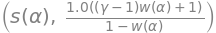

In [357]:
# Keeping track of both symboilic and explicit expressions

atls._s(_α), atls.s(_α)

In [358]:
atls.energy(state)

In [359]:
model = ModelAnalysis(atls)
model.criterion()

        2 ⎛d       ⎞│                         
1.5⋅E₀⋅t ⋅⎜──(a(β))⎟│                         
          ⎝dβ      ⎠│β=0        ⎛d       ⎞│   
──────────────────────── + 3⋅w₁⋅⎜──(w(β))⎟│   
            2                   ⎝dβ      ⎠│β=0
           L                                  

In [360]:
# model.model.energy(state)

# Substitutions for homogeneous state

_homogeneous_damage = {a: β for a in state["α"]}
_homogeneous_strain = {e: model._e for e in state["e"]}
_homogeneous_damage, _homogeneous_strain


In [361]:
_homogeneous_strain

In [362]:

atls.energy(state).subs(_homogeneous_strain).subs({a: _α for a in state["α"]})/_N



In [363]:
(model.criterion()/_N).doit()

        2 ⎛d       ⎞│                       
0.5⋅E₀⋅t ⋅⎜──(a(β))⎟│                       
          ⎝dβ      ⎠│β=0      ⎛d       ⎞│   
──────────────────────── + w₁⋅⎜──(w(β))⎟│   
            2                 ⎝dβ      ⎠│β=0
           L                                

Damage criterion (first order optimality) is independent of N

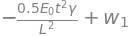

In [364]:
model.explicit_criterion()/_N

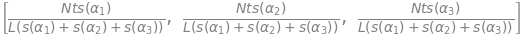

In [365]:
[e for e in model._equilirbrium_e()]

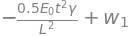

In [366]:
tc, criterion = model.critical_load()

(criterion/_N).subs({N: _N}).doit()

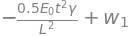

In [367]:
(criterion/_N).doit()

In [368]:
(criterion/_N).subs(_matpar).doit()

In [369]:
sp.solve(criterion/_N, sp.symbols('t')**2)

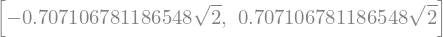

In [370]:
[t.subs(_matpar) for t in tc]

Energy as a function of $\alpha$ alone

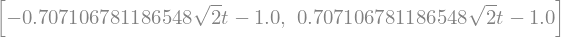

In [339]:
_homogeneous_energy = model.energy_fc_alpha()   \
    .replace(sp.Function('a'), model.model.a )    \
    .replace(sp.Function('w'), model.model.w)       \
    .subs(_homogeneous_damage)

_homogeneous_energy

_homo_crit = sp.diff(_homogeneous_energy, sp.symbols('β'))

sols = sp.solve(_homo_crit, sp.symbols('β'))

[s.subs(_matpar) for s in sols]


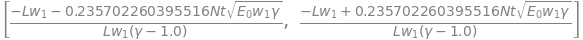

In [340]:
evo_β = sp.diff(model.energy_fc_alpha().subs(_homogeneous_damage), sp.symbols('β')) \
    .replace(sp.Function('a'), model.model.a )    \
    .replace(sp.Function('w'), model.model.w).doit().simplify()


sp.solve(evo_β, sp.symbols('β'))

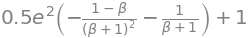

In [341]:
sp.diff(model.model.energy(state)                   \
            .subs(_homogeneous_damage)              \
            .subs(_homogeneous_strain), β)          \
        .replace(sp.Function('a'), model.model.a )  \
        .replace(sp.Function('w'), model.model.w)   \
            .subs(_matpar).doit()/_N

## Model Analysis

- (constitutive assumptions)
- equilibrium
- homogeneous solution
- homogeneous energy
- bifurcations
- stability

In [342]:
N = sp.symbols("N")
t = sp.symbols('t')
_N = 2

γ = sp.symbols('γ')
E0, L, w1, σc = sp.symbols('E0 L w1 σc')

u = sp.symbols([f"u{i}" for i in range(0, _N)])
e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
α = sp.symbols([f"α{i}" for i in range(1, _N+1)])
_α = sp.symbols("α")

β = sp.symbols('β')
αt = sp.symbols('α_t')


state = {"u": u, "α": α, "e": e}
_matpar = {N: _N, γ: 2, E0: 1, w1: 1, L: 1}
matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}



In [343]:
_α

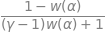

In [344]:
atls.a(_α)

In [345]:
atls = SymbolicDiscreteDamage(state, matpar)
model = ModelAnalysis(atls)
model.criterion()

        2 ⎛d       ⎞│                         
1.0⋅E₀⋅t ⋅⎜──(a(β))⎟│                         
          ⎝dβ      ⎠│β=0        ⎛d       ⎞│   
──────────────────────── + 2⋅w₁⋅⎜──(w(β))⎟│   
            2                   ⎝dβ      ⎠│β=0
           L                                  

In [346]:
sp.solve(model.criterion().replace(sp.Function('a'), atls.a) \
                    .replace(sp.Function('w'), atls.w).doit(), sp.symbols('t')**2)

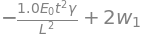

In [347]:
model.explicit_criterion().doit()

(<Figure size 576x432 with 4 Axes>,
 array([<AxesSubplot:ylabel="a, a', a''">, <AxesSubplot:>], dtype=object))

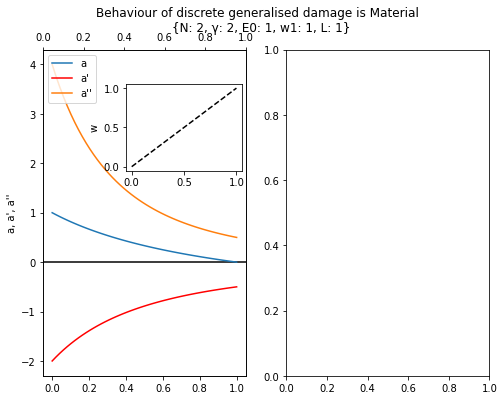

In [348]:
model.plot_material(_matpar)

In [349]:
atls.energy(state)

In [19]:
state

{'u': [u0, u1], 'α': [α1, α2], 'e': [e1, e2]}

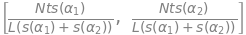

In [20]:
model._equilirbrium_e()


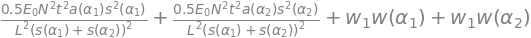

In [21]:
model.energy_fc_alpha()

In [247]:
subs_homog_α, subs_homog_e =  model._state_homog_substitutions(state, _matpar)
subs_homog_α

In [248]:
subs_homog_e

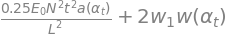

In [212]:
model.energy_fc_alpha().subs(subs_homog_α)

### homogeneous solution

In [23]:
_derivative_homo_α_wrt_t = [sp.diff(_homo_α.subs(_matpar), sp.symbols('t')) 
                            for _homo_α in model.homogeneous_α(_matpar)]

_idx = np.where(np.array(_derivative_homo_α_wrt_t) > 0)[0][0]

model.set_homog_solution_idx(_idx)
# model._homog_solution_idx

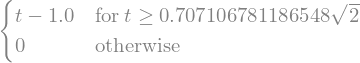

In [217]:
model.homogeneous_α_wrt_t(_matpar)

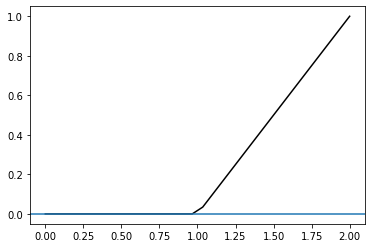

In [218]:
_loads = np.linspace(0., float(γ.subs(_matpar)), 30)

# _alpha = model.homogeneous_α(_matpar)[model._homog_solution_idx]
_alpha = model.homogeneous_α_wrt_t(_matpar)

_f = sp.lambdify(t, _alpha.subs(_matpar), 'numpy')
plt.plot(_loads, _f(_loads), c='k')

plt.axhline(0)

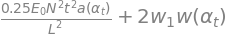

In [222]:
# energies wrt t

model.energy_fc_alpha() \
    .subs(subs_homog_α)

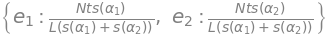

In [219]:
model.equilibrium_subs()

In [220]:
# Substitutions to compute homogeneous solutions

subs_homog_α, subs_homog_e =  model._state_homog_substitutions(state, _matpar)
subs_homog_α, subs_homog_e


In [249]:
subs_homog_e

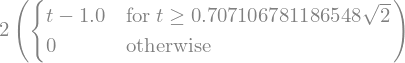

In [239]:
model.model._damage(state)      \
    .subs(subs_homog_α)         \
    .replace(sp.Function('w'), model.model.w)                  \
    .replace(αt, _αt)       \
    .subs(_matpar)



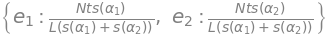

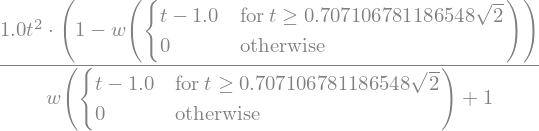

In [257]:

_elastic_energy_homogeneous_wrt_t

### Plots of homogeneous response

In [264]:
_tc, _ = model.critical_load()
_tc = _tc[model._homog_solution_idx].subs(matpar)


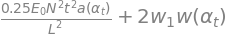

In [279]:
model.energy_fc_alpha()     \
    .subs(subs_homog_α)    

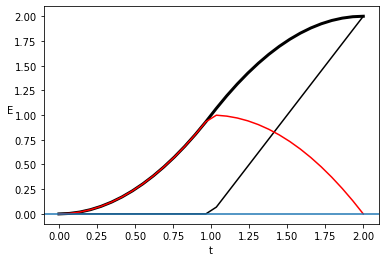

In [265]:
_αt = model.homogeneous_α_wrt_t(_matpar)

energy_homogeneous_wrt_t = model.energy_fc_alpha()     \
    .subs(subs_homog_α)     \
    .replace(αt, _αt)       \
    .replace(sp.Function('a'), model.model.a)                  \
    .replace(sp.Function('w'), model.model.w)                  \
    .subs(_matpar)

_damage_energy_homogeneous_wrt_t = model.model._damage(state)      \
    .subs(subs_homog_α)         \
    .replace(sp.Function('w'), model.model.w)                  \
    .replace(αt, _αt)       \
    .subs(_matpar)

_elastic_energy_homogeneous_wrt_t = model.model._elastic(state)      \
                .subs(model.equilibrium_subs())                       \
                .subs(subs_homog_α)                                     \
                    .replace(sp.Function('a'), model.model.a)                  \
                    .replace(sp.Function('w'), model.model.w)                  \
                    .replace(αt, _αt)                                       \
                    .subs(_matpar)


_f1 = sp.lambdify(t, energy_homogeneous_wrt_t, 'numpy')
_f2 = sp.lambdify(t, _damage_energy_homogeneous_wrt_t, 'numpy')
_f3 = sp.lambdify(t, _elastic_energy_homogeneous_wrt_t, 'numpy')


plt.plot(_loads, _f1(_loads), c='k' , lw=3)
plt.plot(_loads, _f2(_loads), c='k')
plt.plot(_loads, _f3(_loads), c='r')

plt.xlabel('t')
plt.ylabel('E', rotation=0)


plt.axhline(0)

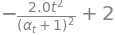

In [231]:
model.evo_α(matpar = _matpar)

In [104]:
_homogeneous = {a: β for a in state["α"]}
_sound = {a: 0 for a in state["α"]}

In [105]:
_sound, _homogeneous

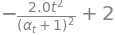

In [232]:
model.evo_α(_matpar)

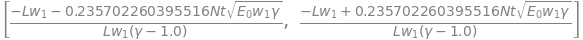

In [37]:
model.homogeneous_α()

In [ ]:
model.homogeneous_α(_matpar)

In [67]:
subs_homog_α, subs_homog_e =  model._state_homog_substitutions(state, _matpar)

In [266]:
atls = SymbolicDiscreteDamage(state, matpar)
model = ModelAnalysis(atls)
model.criterion()

        2 ⎛d       ⎞│                         
1.0⋅E₀⋅t ⋅⎜──(a(β))⎟│                         
          ⎝dβ      ⎠│β=0        ⎛d       ⎞│   
──────────────────────── + 2⋅w₁⋅⎜──(w(β))⎟│   
            2                   ⎝dβ      ⎠│β=0
           L                                  

In [267]:
# we bifurcate m springs

m = 1

assert m < _matpar[N]

In [268]:
bif_α, homo_α, bif_e, homo_e = model._state_split(m, state, _matpar)
print(f'set of bifurcated springs {bif_α}')
print(f'set of homogeneous springs {homo_α}')

set of bifurcated springs [α2]
set of homogeneous springs {α1}


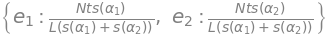

In [275]:
model.equilibrium_subs()

In [269]:
subs_bif_α, subs_bif_e =  model._state_bifurcation_substitutions(1, state, _matpar)

In [270]:
model.homogeneous_α(_matpar).replace(_a, model.model.a)  \
            .replace(_w, model.model.w).doit()

In [271]:
# substitutions for strain

subs_bif_e

In [280]:
_s

In [307]:
subs_bif_α

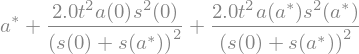

In [316]:
model.energy_fc_alpha()         \
    .subs(_matpar)              \
    .subs(subs_bif_α)           \
    .subs({sp.symbols('α_t'): 0})      \
    .replace(_w, model.model.w)             \
    .replace(sp.Function('s'), atls.s)      \
    
                                       

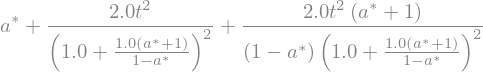

In [305]:

_en_alpha_bifurcations = model.energy_fc_alpha()        \
    .subs(subs_bif_α)                                  \
    .subs({sp.symbols('α_t'): 0})      \
    .replace(sp.Function('s'), atls.s)      \
    .replace(_a, model.model.a)             \
    .replace(_w, model.model.w)             \
    .subs(_matpar)                                     


_en_alpha_bifurcations

In [306]:
sp.diff(_en_alpha_bifurcations, sp.symbols("a^*")).simplify()

In [290]:
# The energy of the bifurcated system

_en_alpha_bifurcations = model.energy_fc_alpha()        \
    .subs(subs_bif_α).subs({sp.symbols('α_t'): 0})

_en_alpha_bifurcations = _en_alpha_bifurcations  \
            .replace(_a, model.model.a)  \
            .replace(sp.Function('s'), atls.s)      \
            .replace(_w, model.model.w)        \
            .subs(_matpar).simplify()

# sp.diff(_en_alpha_bifurcations, sp.symbols("a^*"))

In [ ]:

# The derivative of the energy in the direction of bifurcations, 
# computed for the model at hand, for the bifurcated solutions 

_en_bif_model_prime = sp.diff(_en_alpha_bifurcations, sp.symbols("a^*")) \
            .replace(_a, model.model.a)  \
            .replace(_w, model.model.w).doit()


In [ ]:
_en_alpha_bifurcations

In [ ]:
_bif_crit = sp.diff(_en_alpha_bifurcations, sp.symbols("a^*"))      \
    .replace(sp.Function('s'), atls.s)      \
    .replace(sp.Function('w'), atls.w)      \
    .replace(_a, model.model.a)             \
    .replace(_w, model.model.w)             \
    .subs(_matpar).simplify()

_bif_crit

In [ ]:
_bif_crit.factor(sp.symbols("a^*")), 

In [ ]:
sp.solve(_bif_crit.factor(sp.symbols("a^*")), sp.symbols("a^*"))

## Sandbox


In [218]:
N = sp.symbols("N")
t = sp.symbols('t')
γ = sp.symbols('γ')
E0, L, w1, σc = sp.symbols('E0 L w1 σc')
_α = sp.symbols("α")
β = sp.symbols('β')
αt = sp.symbols('α_t')


for _N in range(1, 4):

# _N = 2

    u = sp.symbols([f"u{i}" for i in range(0, _N)])
    e = sp.symbols([f"e{i}" for i in range(1, _N+1)])
    α = sp.symbols([f"α{i}" for i in range(1, _N+1)])

    state = {"u": u, "α": α, "e": e}
    _matpar = {N: _N, γ: 2, E0: 1, w1: 1, L: 1}
    matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}

    atls = SymbolicDiscreteDamage(state, matpar)
    model = ModelAnalysis(atls)
    # print(model.criterion())

    subs_homog_α, subs_homog_e =  model._state_homog_substitutions(state, _matpar)

    # print(subs_homog_α)
    print(energy_fc_alpha(model))


NameError: name 'energy_fc_alpha' is not defined

In [ ]:
[i for i in range(1, 3)]